In [1]:
import numpy as np
import pandas as pd 
import datetime
from tqdm import tqdm
import pandas_datareader.naver as web_naver
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(20,10)})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
start = '2008-12-01'
end = '2021-11-30'

In [4]:
price_month=pd.read_csv('price_panel_monthend.csv',index_col=0,parse_dates=True)
price_month.head()

,014160,003560,004370,013360,003640,005385,003547,112610,014990,013240,...,004710,170900,185750,136490,210540,267250,004105,005930,006805,006375
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-30,235,1540,244500,540,14400.0,12800,5600,NaN,1015,2110.0,...,8822,NaN,NaN,NaN,NaN,NaN,326.0,9020,3613,97000.0
2009-01-30,275,1285,200500,539,14150.0,13700,6550,NaN,1005,2035.0,...,11673,NaN,NaN,NaN,NaN,NaN,290.0,9760,4671,91000.0
2009-02-27,265,1210,227000,545,12000.0,15150,6310,NaN,855,1705.0,...,12352,NaN,NaN,NaN,NaN,NaN,278.0,9540,4185,97800.0
2009-03-31,315,1170,215000,620,13600.0,18600,6520,NaN,1100,2310.0,...,18154,NaN,NaN,NaN,NaN,NaN,285.0,11360,5164,93000.0
2009-04-30,400,1360,216000,715,17650.0,20800,6950,NaN,1245,3315.0,...,16898,NaN,NaN,NaN,NaN,NaN,351.0,11840,5588,118500.0


# 듀얼 모멘텀 포트폴리오 구성
1. 듀얼 모멘텀은 시계열 모멘텀과 횡단면 모멘텀을 함께 고려하는 전략이다.
2. Winner의 경우 횡당면 모멘텀 기준 상위 종목 중에서 과거 수익률이 0이상인 종목들로 구성된 포트폴리오다.
3. Loser의 경우 횡당면 모멘텀 기준 하위 종목 중에서 과거 수익률이 0미만인 종목들로 구성된 포트폴리오다.

In [6]:
def winner_construction(price_month, k,start,end):
  rtn=np.log(price_month/price_month.shift(1))*100
  mom_k=np.log(price_month/price_month.shift(k))*100
  rtn = rtn.iloc[1:]
  mom_k = mom_k.iloc[k:]
  mom_k = mom_k.shift(1)
  mom_k = mom_k.iloc[1:]

  rtn = rtn.reindex(mom_k.index)

  date_return_tickers = dict()

  for i in range(len(mom_k)):
    winners = mom_k.iloc[i].dropna().rank(method='first',ascending=False)\
    [(mom_k.iloc[i].dropna().rank(method='first',ascending=False)<end) & \
    ((mom_k.iloc[i].dropna().rank(method='first',ascending=False)>=start))].index.values
    winners = list(winners)
    mom_k1=mom_k[winners].copy()
    mom_k2=mom_k1[mom_k1>0]
    winners=mom_k2.iloc[i].index
    winners=list(winners)
    # print(len(winners))
    # print(rtn.iloc[i].reindex(winners).fillna(-99).values)
    date_return_tickers[rtn.index[i]] = \
    [[np.dot(rtn.iloc[i].reindex(winners).fillna(-99).values, np.array([1/len(winners) for i in range(len(winners))]))], winners]
    

  return date_return_tickers

In [7]:
winner_sample = winner_construction(price_month=price_month, k = 6,start=100,end=200)

In [8]:
def loser_construction(price_month, k,start,end):
  rtn=np.log(price_month/price_month.shift(1))*100
  mom_k=np.log(price_month/price_month.shift(k))*100
  rtn = rtn.iloc[1:]
  mom_k = mom_k.iloc[k:]
  mom_k = mom_k.shift(1)
  mom_k = mom_k.iloc[1:]

  rtn = rtn.reindex(mom_k.index)

  date_return_tickers = dict()

  for i in range(len(mom_k)):
    winners = mom_k.iloc[i].dropna().rank(method='first',ascending=False)\
    [(mom_k.iloc[i].dropna().rank(method='first',ascending=False)<end) & \
    ((mom_k.iloc[i].dropna().rank(method='first',ascending=False)>=start))].index.values
    winners = list(winners)
    mom_k1=mom_k[winners].copy()
    mom_k2=mom_k1[mom_k1<0]
    winners=mom_k2.iloc[i].index
    winners=list(winners)
    # print(len(winners))
    # print(rtn.iloc[i].reindex(winners).fillna(-99).values)
    date_return_tickers[rtn.index[i]] = \
    [[np.dot(rtn.iloc[i].reindex(winners).fillna(-99).values, np.array([1/len(winners) for i in range(len(winners))]))], winners]
    

  return date_return_tickers

In [9]:
loser_sample=loser_construction(price_month=price_month,k=6,start=800,end=900)

In [10]:
several_k=[3,6,9,12]

#winner
print('winners')
for k in several_k:
    print(str(k)+'momentum')
    k_winner_dual=winner_construction(price_month=price_month,k=k,start=100,end=200)
    for i in range((11-k),12+(11-k)):
        print(list(k_winner_dual.keys())[i])
        sub=len([x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_winner_dual[list(k_winner_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_winner_dual[list(k_winner_dual.keys())[i-1]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i]][1]])

    for i in range(len(list(k_winner_dual.keys()))-12, len(list(k_winner_dual.keys()))):
        print(list(k_winner_dual.keys())[i])
        sub=len([x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_winner_dual[list(k_winner_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_winner_dual[list(k_winner_dual.keys())[i]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_winner_dual[list(k_winner_dual.keys())[i-1]][1] if x not in k_winner_dual[list(k_winner_dual.keys())[i]][1]])


        

winners
3momentum
2009-12-30 00:00:00
교체비율: 0.8
편입 ['000545', '093820', '017550', '051600', '096775', '051915', '013005', '001045', '000860', '007980', '005620', '005450', '001529', '007540', '006090', '002355', '004250', '037270', '001040', '100220', '035420', '029460', '014825', '004830', '008930', '101790', '003670', '083420', '031440', '003925', '006380', '005305', '017900', '003945', '014820', '021240', '011800', '010960', '009150', '000720', '009835', '037710', '051910', '079430', '031820', '005870', '084670', '041650', '003160', '001687', '002760', '002170', '004380', '002810', '082260', '006120', '005850', '002550', '036570', '003720', '005300', '072710', '004060', '015890', '005250', '004989', '107590', '002700', '096770', '001130', '096300', '002820', '012800', '086280', '005110', '001049', '002840', '032640', '010690', '016800']
퇴출 ['005385', '069460', '004360', '014440', '002140', '005440', '025540', '000270', '005270', '049800', '099210', '093400', '009720', '018880', '000

In [11]:
several_k=[3,6,9,12]

#winner
print('winners')
for k in several_k:
    print(str(k)+'momentum')
    k_loser_dual=loser_construction(price_month=price_month,k=k,start=800,end=900)
    for i in range((11-k),12+(11-k)):
        print(list(k_loser_dual.keys())[i])
        sub=len([x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_loser_dual[list(k_loser_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_loser_dual[list(k_loser_dual.keys())[i-1]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i]][1]])

    for i in range(len(list(k_loser_dual.keys()))-12, len(list(k_loser_dual.keys()))):
        print(list(k_loser_dual.keys())[i])
        sub=len([x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print(f'교체비율: {sub/len(k_loser_dual[list(k_loser_dual.keys())[i-1]][1])}')
        print('편입',[x for x in k_loser_dual[list(k_loser_dual.keys())[i]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i-1]][1]])
        print('퇴출',[x for x in k_loser_dual[list(k_loser_dual.keys())[i-1]][1] if x not in k_loser_dual[list(k_loser_dual.keys())[i]][1]])


        

winners
3momentum
2009-12-30 00:00:00
교체비율: 0.57
편입 ['000420', '007800', '033270', '007570', '015110', '009420', '011700', '004890', '012405', '090370', '017180', '024870', '002460', '072130', '001880', '034830', '000020', '017940', '001745', '008355', '012095', '005500', '033240', '004870', '012200', '006280', '001820', '011070', '000120', '006440', '017170', '066570', '008540', '000910', '004310', '103590', '005960', '016420', '001440', '004550', '000835', '066575', '002390', '077970', '002630', '015590', '003070', '007575', '005420', '109070', '002920', '009470', '001600', '032560', '000425', '009190', '001210']
퇴출 ['014990', '013240', '014590', '008110', '014530', '093230', '008705', '016360', '005010', '011930', '000470', '037270', '001770', '017960', '098150', '002990', '003475', '091090', '004800', '088790', '008320', '003280', '011420', '024890', '009540', '000700', '001515', '009830', '104120', '031820', '005980', '002780', '071050', '008260', '089470', '006800', '015545', '00

KOSPI

In [12]:
kospi=web_naver.NaverDailyReader(symbols='KOSPI', start=start,end=end,adjust_price=True)
kospi=kospi.read()
kospi=kospi.astype(float)

In [13]:
kospi=kospi.loc[price_month.index,:]['Close']
kospi

Date
2008-12-30    1124.47
2009-01-30    1162.11
2009-02-27    1063.03
2009-03-31    1206.26
2009-04-30    1369.36
               ...   
2021-07-30    3202.32
2021-08-31    3199.27
2021-09-30    3068.82
2021-10-29    2970.68
2021-11-30    2839.01
Name: Close, Length: 156, dtype: float64

In [14]:
several_k = [3,6,9,12]

portfolio = pd.DataFrame(index = price_month.index)

for k in tqdm(several_k):
  winner_k = winner_construction(price_month = price_month, k = k,start=100,end=200)
  loser_k = loser_construction(price_month = price_month, k = k,start=800,end=900)
  portfolio['winner'+str(k)] = pd.Series(np.array([rtn[0] for rtn in list(winner_k.values())]).flatten(), index = winner_k.keys())
  portfolio['loser'+str(k)] =  pd.Series(np.array([rtn[0] for rtn in list(loser_k.values())]).flatten(), index = loser_k.keys())

portfolio['KOSPI'] = (np.log(kospi/kospi.shift(1))) * 100 

portfolio = portfolio.iloc[13:]

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


In [15]:
print("mean","\n",portfolio.mean())
print("")
print("std","\n",portfolio.std())
print("")
print("skewness","\n",portfolio.skew())
print("")
print("kurtosis","\n",portfolio.kurtosis())
print("")
print("sharpe ratio","\n", portfolio.mean() / portfolio.std())

mean 
 winner3     0.043022
loser3     -0.192188
winner6     0.112045
loser6     -0.318376
winner9     0.413017
loser9     -0.561429
winner12    0.416832
loser12    -0.758781
KOSPI       0.365744
dtype: float64

std 
 winner3     5.042121
loser3      6.327593
winner6     4.844158
loser6      6.611919
winner9     5.180577
loser9      6.754650
winner12    5.388951
loser12     7.106037
KOSPI       4.201275
dtype: float64

skewness 
 winner3    -0.583404
loser3     -0.342353
winner6    -0.664159
loser6     -0.155988
winner9    -0.755946
loser9      0.081492
winner12   -0.963906
loser12     0.014448
KOSPI      -0.338658
dtype: float64

kurtosis 
 winner3     0.906482
loser3      1.803253
winner6     0.710545
loser6      1.654844
winner9     1.377862
loser9      1.294010
winner12    2.387771
loser12     1.235644
KOSPI       1.676392
dtype: float64

sharpe ratio 
 winner3     0.008532
loser3     -0.030373
winner6     0.023130
loser6     -0.048152
winner9     0.079724
loser9     -0.083117
winn

<AxesSubplot:xlabel='Date'>

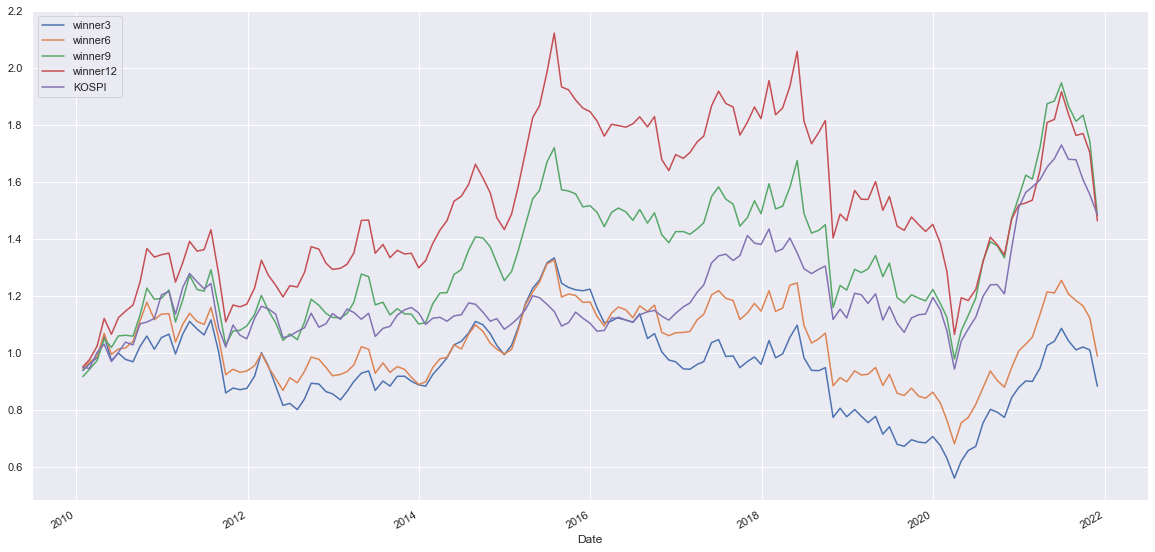

In [16]:
##winners
winners = portfolio[['winner3','winner6','winner9','winner12','KOSPI']] / 100
(1+winners).cumprod().plot()

<AxesSubplot:xlabel='Date'>

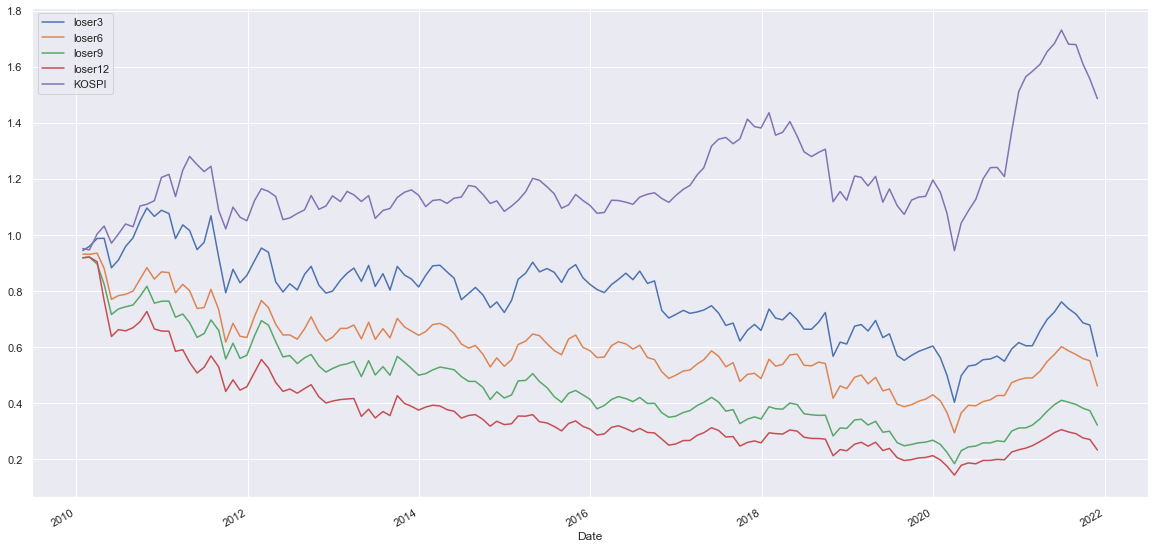

In [17]:
##losers
losers = portfolio[['loser3','loser6','loser9','loser12','KOSPI']]
(1+(losers/100)).cumprod().plot()